# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getDataLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net
from mylibs.loss import loss_function
from mylibs.report import report_summary

import torch
from torchvision import transforms

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 50
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

## Baseline #1, use only first K-class labelled data to train

In [4]:
train_data_loader, test_data_loader = getDataLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, mode=6, USE_GPU=USE_GPU)

Epoch: 1 Loss: 0.5668 Accuracy: 0.7997 F1_score: 0.7976
Epoch: 2 Loss: 0.4018 Accuracy: 0.8540 F1_score: 0.8530
Epoch: 3 Loss: 0.3614 Accuracy: 0.8681 F1_score: 0.8673
Epoch: 4 Loss: 0.3344 Accuracy: 0.8789 F1_score: 0.8782
Epoch: 5 Loss: 0.3147 Accuracy: 0.8865 F1_score: 0.8860
Epoch: 6 Loss: 0.2972 Accuracy: 0.8934 F1_score: 0.8928
Epoch: 7 Loss: 0.2840 Accuracy: 0.8982 F1_score: 0.8978
Epoch: 8 Loss: 0.2707 Accuracy: 0.9032 F1_score: 0.9028
Epoch: 9 Loss: 0.2599 Accuracy: 0.9081 F1_score: 0.9078
Epoch: 10 Loss: 0.2507 Accuracy: 0.9109 F1_score: 0.9105
Epoch: 11 Loss: 0.2413 Accuracy: 0.9157 F1_score: 0.9154
Epoch: 12 Loss: 0.2324 Accuracy: 0.9177 F1_score: 0.9175
Epoch: 13 Loss: 0.2245 Accuracy: 0.9215 F1_score: 0.9213
Epoch: 14 Loss: 0.2169 Accuracy: 0.9255 F1_score: 0.9253
Epoch: 15 Loss: 0.2106 Accuracy: 0.9263 F1_score: 0.9261
Epoch: 16 Loss: 0.2032 Accuracy: 0.9294 F1_score: 0.9292
Epoch: 17 Loss: 0.1975 Accuracy: 0.9322 F1_score: 0.9320
Epoch: 18 Loss: 0.1918 Accuracy: 0.9353 

<Figure size 432x288 with 0 Axes>

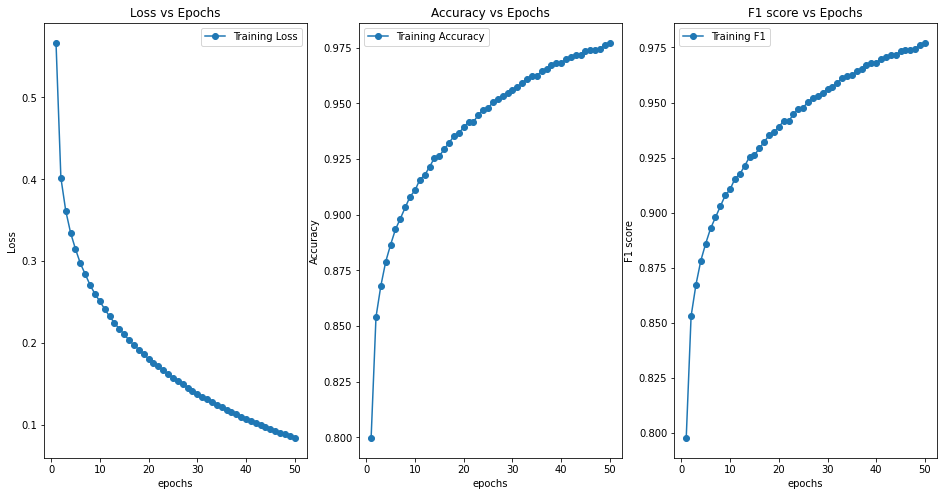

In [5]:
model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
eval_metrics = []

# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, EPOCH+1):
    eval_metric = train(train_data_loader, model, loss_function, optimizer, USE_GPU)
    eval_metrics.append(eval_metric)
    print(f"Epoch: {epoch} Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
report_summary(eval_metrics)

In [6]:
model.eval()
eval_metric = validate(test_data_loader, model, loss_function, USE_GPU)
print(f"Result on test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

Result on test set: Loss: 4.3374 Accuracy: 0.6123 F1_score: 0.5272


## Baseline #2, use full Fashion-MNIST dataset to train

In [7]:
train_data_loader, test_data_loader = getDataLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, mode=7, USE_GPU=USE_GPU)

Epoch: 1 Loss: 0.4935 Accuracy: 0.8298 F1_score: 0.8285
Epoch: 2 Loss: 0.3434 Accuracy: 0.8802 F1_score: 0.8796
Epoch: 3 Loss: 0.3053 Accuracy: 0.8927 F1_score: 0.8923
Epoch: 4 Loss: 0.2792 Accuracy: 0.9012 F1_score: 0.9008
Epoch: 5 Loss: 0.2599 Accuracy: 0.9092 F1_score: 0.9089
Epoch: 6 Loss: 0.2444 Accuracy: 0.9148 F1_score: 0.9146
Epoch: 7 Loss: 0.2312 Accuracy: 0.9188 F1_score: 0.9186
Epoch: 8 Loss: 0.2191 Accuracy: 0.9237 F1_score: 0.9235
Epoch: 9 Loss: 0.2087 Accuracy: 0.9280 F1_score: 0.9278
Epoch: 10 Loss: 0.1988 Accuracy: 0.9314 F1_score: 0.9312
Epoch: 11 Loss: 0.1907 Accuracy: 0.9345 F1_score: 0.9344
Epoch: 12 Loss: 0.1828 Accuracy: 0.9381 F1_score: 0.9379
Epoch: 13 Loss: 0.1754 Accuracy: 0.9395 F1_score: 0.9393
Epoch: 14 Loss: 0.1689 Accuracy: 0.9439 F1_score: 0.9437
Epoch: 15 Loss: 0.1624 Accuracy: 0.9461 F1_score: 0.9460
Epoch: 16 Loss: 0.1562 Accuracy: 0.9469 F1_score: 0.9468
Epoch: 17 Loss: 0.1508 Accuracy: 0.9501 F1_score: 0.9500
Epoch: 18 Loss: 0.1457 Accuracy: 0.9519 

<Figure size 432x288 with 0 Axes>

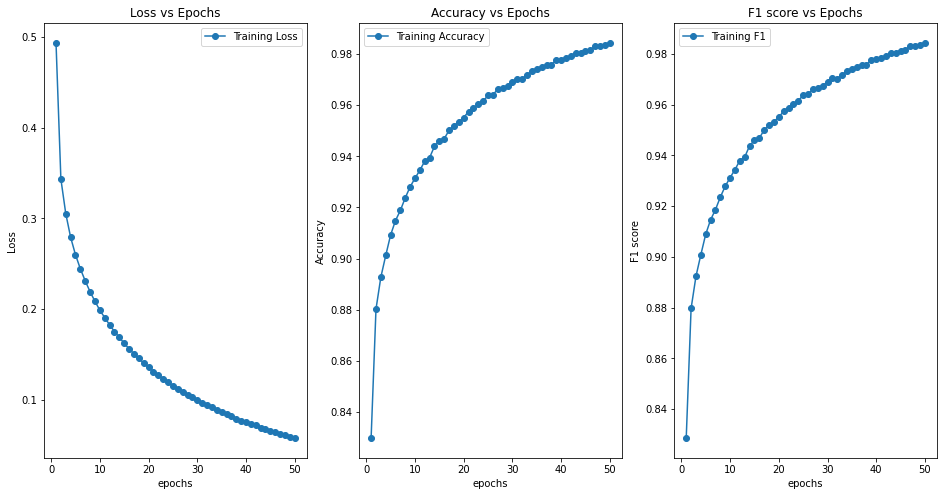

In [8]:
model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
eval_metrics = []

# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, EPOCH+1):
    eval_metric = train(train_data_loader, model, loss_function, optimizer, USE_GPU)
    eval_metrics.append(eval_metric)
    print(f"Epoch: {epoch} Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
report_summary(eval_metrics)

In [9]:
model.eval()
eval_metric = validate(test_data_loader, model, loss_function, USE_GPU)
print(f"Result on test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

Result on test set: Loss: 0.3652 Accuracy: 0.8978 F1_score: 0.8977
